In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime, time, requests
from time import sleep

In [2]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

In [3]:
covid_19_data = pd.read_csv('covid_19_data.csv')
#Convert the date to todays date
covid_19_data['ObservationDate'] = pd.to_datetime(covid_19_data['ObservationDate'])
#Sorting data in ascending order to get new data daily
covid_19_data = covid_19_data.sort_values('ObservationDate', ascending=True)
print('Shape:', covid_19_data.shape)
print('Date min:', np.min(covid_19_data['ObservationDate']), 'Date max:', np.max(covid_19_data['ObservationDate']))
# replace NaN Provinces with string
covid_19_data['Province/State'] = covid_19_data['Province/State'].fillna('No_Province')
covid_19_data.head()

Shape: (53927, 8)
Date min: 2020-01-22 00:00:00 Date max: 2020-06-30 00:00:00


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
21,22,2020-01-22,Ningxia,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
22,23,2020-01-22,Qinghai,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
23,24,2020-01-22,Shaanxi,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
24,25,2020-01-22,Shandong,Mainland China,1/22/2020 17:00,2.0,0.0,0.0


In [4]:
#How many null values are there?
count_nan = len(covid_19_data) - covid_19_data.count()
count_nan

SNo                0
ObservationDate    0
Province/State     0
Country/Region     0
Last Update        0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

In [5]:
# How many countries do we have?
countries =list(set(covid_19_data['Country/Region']))
print('Unique Country/Regio found:', str(len(countries)))
countries

Unique Country/Regio found: 223


['Israel',
 'Lebanon',
 'Congo (Brazzaville)',
 'Romania',
 'Austria',
 'US',
 'Armenia',
 'North Ireland',
 'Iran',
 'United Arab Emirates',
 'Tunisia',
 'Bosnia and Herzegovina',
 'Kuwait',
 'Guadeloupe',
 'The Bahamas',
 'The Gambia',
 'Italy',
 'Saint Vincent and the Grenadines',
 'Grenada',
 'Belarus',
 'Zimbabwe',
 'Comoros',
 'Liechtenstein',
 'Mozambique',
 'Slovakia',
 'Fiji',
 'Uruguay',
 'Guinea',
 'Burma',
 "('St. Martin',)",
 'Colombia',
 'Lithuania',
 'Burkina Faso',
 'East Timor',
 'Uganda',
 'Sri Lanka',
 'Angola',
 'Norway',
 'Croatia',
 'French Guiana',
 'Dominican Republic',
 'Malta',
 'Costa Rica',
 'Nigeria',
 'Nicaragua',
 'Eswatini',
 'Taiwan',
 'Yemen',
 'Canada',
 'Mali',
 'Cape Verde',
 'Netherlands',
 'Vatican City',
 'Central African Republic',
 'UK',
 'Lesotho',
 'Haiti',
 'Namibia',
 'MS Zaandam',
 'Bahrain',
 'Tajikistan',
 'Chile',
 'Puerto Rico',
 'Morocco',
 'Singapore',
 'Belgium',
 'Senegal',
 'Tanzania',
 'Philippines',
 'San Marino',
 'Iraq',
 'Nep

In [6]:
#We have to find the central latitude and longitude 
def get_lat_lon(zone, 
                output_as = 'center'):
    # thanks openstreetmap! 
    # create url
    url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search?q=',
                             zone,
                             '&format=json&polygon=0')
    # send out request to Openstreetmap
    response = requests.get(url).json()[0]

    # parse response to list
    if output_as == 'boundingbox':
        lst = response[output_as]
        output = [float(i) for i in lst]
    if output_as == 'center':
        lst = [response.get(key) for key in ['lon','lat']]
        output = [float(i) for i in lst]
        
    return output

In [7]:
#Checking ::  Biratnagar=Home
get_lat_lon('Biratnagar')

[87.281617, 26.4623007]

In [8]:
geo_centers_lon = []
geo_centers_lat = []
total_ctry = len(countries)
counter_ = 0
for ctry in countries:
    if counter_ % 10 == 0: print(total_ctry - counter_)
    #Timer is useful for being safe on the Openstreetmap
    time.sleep(0.2)
    centroid = [None, None]
    #We try to put try & except for the lat/lon
    try:
        centroid = get_lat_lon(ctry, output_as='center')

    except:
        print('Could not find:', ctry)
        
    geo_centers_lon.append(centroid[0])
    geo_centers_lat.append(centroid[1])
        
     
    counter_ += 1

223
213
203
193
183
173
163
153
143
133
123
113
103
93
83
73
63
53
43
33
23
Could not find: occupied Palestinian territory
13
3


In [9]:
# Adding all the geos back to data frame
full_lats = []
full_lons = []
#looping through dataframe
#iterrow helps to loop through data row-by-row
for i, r in covid_19_data.iterrows():
    country = r['Country/Region']
    index_list = countries.index(country)
    full_lats.append(geo_centers_lat[index_list])
    full_lons.append(geo_centers_lon[index_list])
     
# add to data frame
covid_19_data['Longitude'] = full_lons
covid_19_data['Latitude'] = full_lats
covid_19_data.head(2)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Longitude,Latitude
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,72.83357,19.140625
21,22,2020-01-22,Ningxia,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,72.83357,19.140625


In [70]:
def plot_world_map(virus_data, date, save_to_file_name = ''):
    # Set the dimension of the figure
    #plt.figure(figsize=(16, 8))
    # Set the dimension of the figure
    my_dpi=96
    plt.figure(figsize=(4000/my_dpi, 2800/my_dpi), dpi=my_dpi)

    # Make the background map
    m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
    m.drawmapboundary(fill_color='#b8d6e6', linewidth=0)
    m.fillcontinents(color='grey', alpha=0.3)
    m.drawcoastlines(linewidth=0.1, color="white")
    
    total_cases = np.sum(virus_data['Confirmed'])

    # Add a point per position
    m.scatter(virus_data['Longitude'], 
              virus_data['Latitude'], 
              s = virus_data['Confirmed'] * 0.3, # play around with the size or use np.log if you dont like the big circles
              alpha=0.3, 
              c=virus_data['labels_enc'], 
              cmap="Set1")

    plt.title(str(date) + ' Confirmed Covid-19 Cases: ' + str(int(total_cases)) + '\n(circles not to scale)', fontsize=50)
    
    if save_to_file_name != '':
        plt.savefig(save_to_file_name)
        
    plt.show()

In [71]:
# Creating color map
# prepare a color for each point depending on the continent.
covid_19_data['labels_enc'] = pd.factorize(covid_19_data['Country/Region'])[0]
covid_19_data['labels_enc']

0         0
21        0
22        0
23        0
24        0
         ..
53443    98
53444    27
53445     8
53447    30
53926    80
Name: labels_enc, Length: 53927, dtype: int64

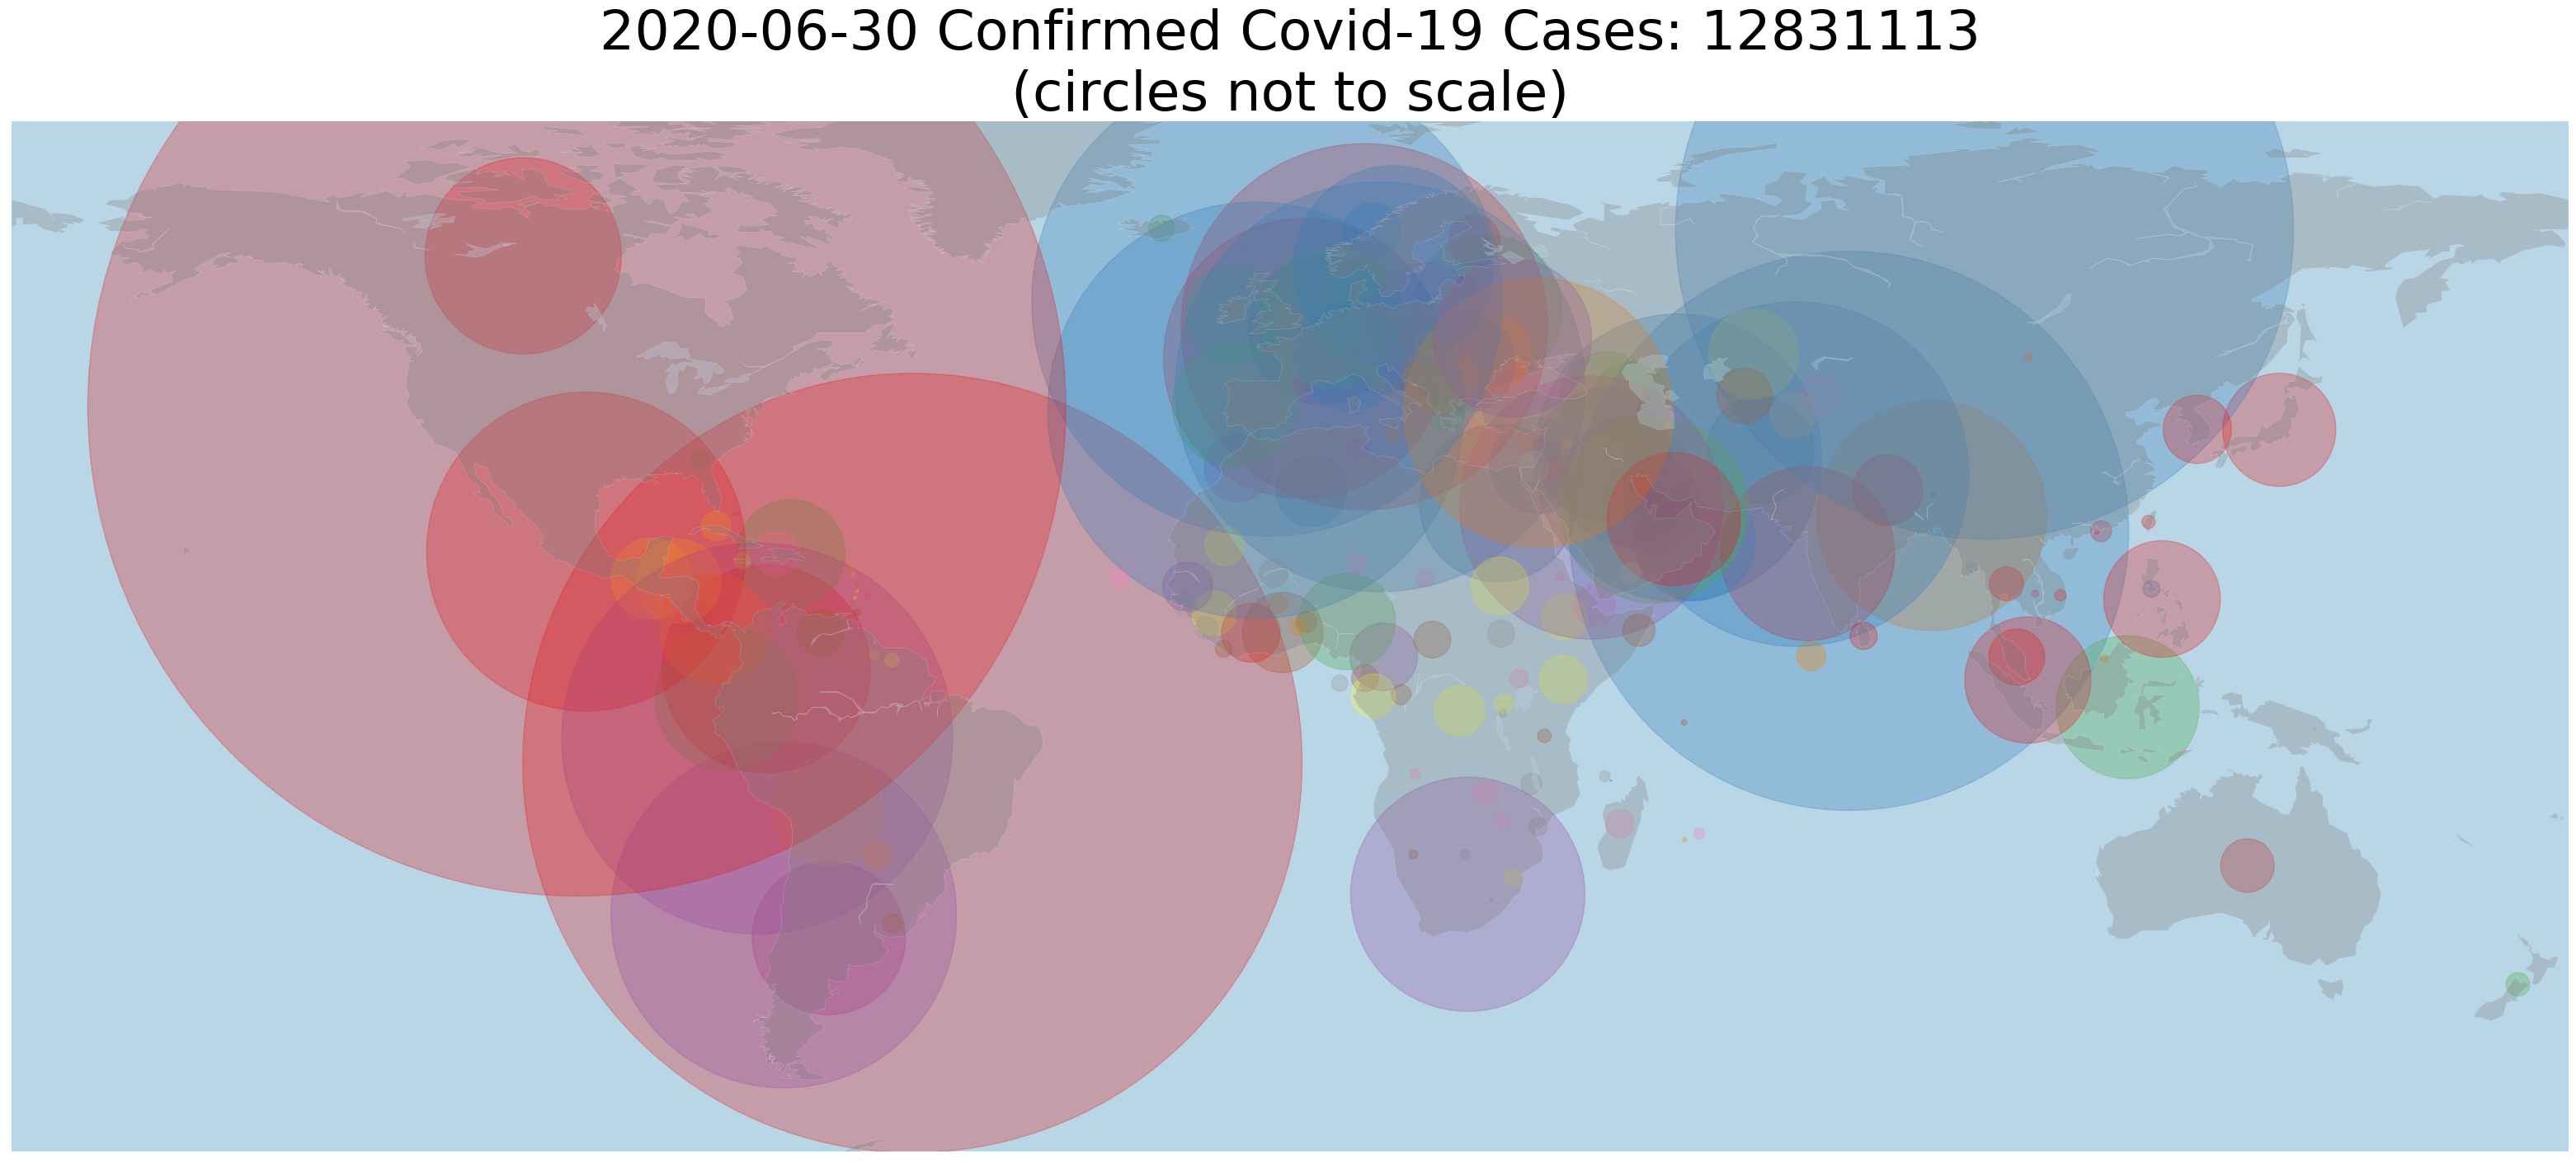

In [73]:
date = '2020-06-30' 

virus_up_to_today = covid_19_data[covid_19_data['ObservationDate'] <= date]

# simplify data set
virus_up_to_today = virus_up_to_today[['Country/Region','Province/State', 'labels_enc', 'Confirmed',
                     'Deaths', 'Recovered',
                     'Longitude', 'Latitude']]


# get totals by province then by country as these are cumulative values by province first then by country and not all countries have provinces

# group by country and sum/mean values
virus_up_to_today=virus_up_to_today.groupby(['Country/Region', 'Province/State', 'labels_enc']).agg({'Confirmed':'last', 
                           'Deaths':'last',
                           'Recovered':'last',
                           'Longitude':'mean',
                          'Latitude':'mean'}).reset_index()



# group by country and sum/mean values
virus_up_to_today=virus_up_to_today.groupby(['Country/Region', 'labels_enc']).agg({'Confirmed':'sum', 
                           'Deaths':'sum',
                           'Recovered':'sum',
                           'Longitude':'mean',
                          'Latitude':'mean'}).reset_index()

# map out confirmed cases
plot_world_map(virus_up_to_today, str(date)[0:10])